## Algorithms in Molecular Biology

First of all, we import all required packages for running the notebook.

In [1]:
import matplotlib.pyplot as plt
import random
import timeit
import time
import numpy as np
import pandas as pd
from itertools import product, combinations
from tqdm import tqdm

# Introduction


The identification of a sequence, plays a very important role in most operations of cell cycle. Looking closer to the DNA replication, DNA transcription or RNA translation, all three opreations depend on the identification of a specific sequences that regulate either the initiation or the temination of the operation. The cells have mechanisms to perform the identification of a regulatory sequence, that are are able to identify a degenerated sequence as well. For the purpose of this Assignment, we will focus on DNA transcription, which is the initiation of a specific gene expression. In the upstream region of the gene, that is the initiation site of the DNA transciption, exist specific recognition sequences (regulatory motifs), where transcription factors (proteins) bind in order to stimulate or supress the expression of the specific gene. A regulatory motif can be not gene-specific, and thus regulatory motifs can exist in the initiation site of multiple genes. The identification of such motifs is of great importance, for targeting a specific gene expression and thus a specific disease. We are going to compare three different algorithms that aim to identify such regulatory motifs, using a synthetic dataset of 10 DNA strings randomly constructed, in each of which the original or a mutated motif of various lengths has been used. The three algorithms, Brute Force, Greedy Search and Randomized Search, use different approaches to deal with the problem of identifying the implanted sequences and they are going to be compared in terms of execution time and accuracy of their prediction.

# Methods

# Synthetic Dataset Generation

In order to perform the exepriments regarding the efficiency of the three different algorithms, we generate a synthtic dataset of dna strings of different sizes, that contain randomly implanted subsequences, that represent the regulatory motifs (k-mers). The number $k$ refers to the length of the motif, e.g. a 15-mer is a string of legth $15$. Moreover, some of the randomly implanted $k$-mers are artificially mutated. A mutation is an alteration in the DNA sequence. There are different type of mutations, point mutations, insertions, deletions etc. For the purpose of this assignment, we deal only with point mutations, that are considered to be a mismatch in a specific position of the sequence, where the initial base is replaced by another base. Therefore, we mutate the k-mers by creating mismatches in them. The number of mismatches ,$d$ , is considered to be less than $\frac{k}{2}$. 


To that end, we are going to create some preliminary functions to help us generate the synthetic dataset. First, we create the `CreateRandStr` function, to generate random strings. The `CreateRandStr`, takes as input the symbols that will be used, in our case the DNA bases (A, T, G, C), and the length of the string that we want to generate.

In [2]:
def CreateRandStr(alphabet,str_len):
    rand_str = ""
    chr_cnt = 0
    while chr_cnt < str_len:
        rand_str = rand_str + alphabet[random.randint(0,len(alphabet)-1)]
        chr_cnt = chr_cnt + 1
    return rand_str

We also store the DNA bases in the variable `bases`.

In [3]:
bases = ["A", "T", "C", "G"]

We will use the `CreateStr` function to generate the random DNA strings as well as the kmers that are going to be implanted in them. We also create the `MutateStr` function to randomly mutate the constructed k-mers by creating mismatches in random positions in them. The `MutateStr` function, takes as input an `alphabet`, in our case the DNA bases, the `string` that will be mutated, and an integer `d`, representing the number of mutations.

In [4]:
def MutateStr(alphabet,string, d):
    # Create d random positions (indices). 
    rand_idx = random.sample(list(range(0,len(string))), d)
    # Create a list of the bases of the kmer.
    _string = list(string)
    
    # For each generated position of the kmer, change its element with a random element from the alphabet given
    for i in rand_idx:
        _string[i] =  alphabet[random.randint(0,len(alphabet)-1)]
    # Concatenate the list of the mutated kmer to a string
    mutated_string = ''.join(_string)
    return mutated_string

Furthermore, we create the `Implant` function, to randomly implant the mutated kmers in the generated DNA strings. The function takes as input the `string` and the `kmer`, that will be implanted in arandom position in it. 

In [5]:
def Implant(string, kmer):
    # Create a random position in the string
    rand_pos = random.randint(0,len(string))
    # Represent the string as a list.
    _string = list(string)
    # Insert the kmer in the random position.
    _string.insert(rand_pos, kmer)
    # # Concatenate the list of the altered DNA string to a string
    final_string = ''.join(_string)
    return final_string

Finally, we create the `generate_dataset` function to generate a dataset given the following parameters, that the function takes as input:

- `alphabet` : the alphabet that will be used to generate the initial DNA strings, the kmers, and the mutations, in our case the DNA bases.
- `l` : the length of the initial DNA strings, e.g. the upstream region (initiation site) of a specific gene.
- `t` : the number of the the DNA strings that will be generated.
- `k` : the length of the kmer that will be implanted in the DNA strings and must be identified (regulatory motifs).
- `d` : the maximum number of mismatches allowed to the mutated kmers.

The function, initially cerates `t` randomly generated strings of length `l`, using the alphabet and the `CreateStr` function. Then, it creates the original kmer in the same way, using the alphabet and the `CreateStr` function. Using the `MutateStr`, it created `t`-1 mutated kmers with up to d mismatches, that along with the original kmers are stored in a list. Finally `Implant` function, it implants each kmer of the list in a random position of the initial DNA strings. In the end, it returns the final dataset, that consists of `t` DNA strings of length `l` + `k`, each one having one implanted kmer, either the mutated or the original, that must be identified.

In [6]:
def generate_dataset(alphabet, l, t, k, d):
    # Generate t DNA stings of length l each
    dna_strings = []
    for i in range(t):
        dna_strings.append(CreateRandStr(alphabet, l))
        
    # Create the original kmer that must be identified.
    kmer = CreateRandStr(alphabet, k)
    
    # Create the mutated kmers, with up to d mismatches.
    mutated_kmers = [kmer]
    count = 0 
    while count<t-1:
        count += 1
        for dd in range(1,d+1):
            mutated_kmers.append(MutateStr(alphabet, kmer, dd))
    
    # Implant the mutated kmers, one in each string and hold the results in a list.
    # Return the list of the DNA strings, the initial kmer, and the list of the mutated kmers.
    dataset = []
    for j, dna_string in enumerate(dna_strings):
        dataset.append(Implant(dna_string, mutated_kmers[j]))
        
    return dataset, kmer, mutated_kmers

We define the parameters for the dataset generation, as presented in the cell below. In ordet to assess our algorithms we generate $10$ DNA strings of initial length $100$, to which all the possible combinations of k-d mers will be implanted, for kmers of lengths $6, 7, 8, 9, 10, 12, 15$ and mismatches $1, 2, 3$. Furthermore, we define the time limit to 1 hour for the bruteforce algorithm and the number of runs for the randomized algorithm to $10, 100, 1000$. The last parameters are further analyzed in the following sections.

In [7]:
# The length of each dna string of the dataset.
dna_string_length = 100

# The number of dna strings in the dataset.
dna_string_number = 10

# The range of length of kmers implanted in the dataset.
kmer_length = [6, 7, 8, 9, 10, 12, 15]

# The range of number of mismatches allowed.
mismatches = [1, 2, 3]

# The time limit for the brute force algorithm.
time_limit = 3600

# The number of iterations for the randomized motif search algorithm.
iterations = [10, 100, 1000]

In [8]:
datasets = {}

for k in kmer_length:
    for d in mismatches:
        if d < k/2 :
            result = generate_dataset(bases, dna_string_length, dna_string_number, k, d)
            datasets[k,d] = {'dataset': result[0], 'kmer' : result[1], 'mutated_kmers' : result[2]}
        
datasets = pd.DataFrame(datasets)
datasets

6   \
                                                               1   
dataset        [CGCCCAGATTGGGCGAGTTTCACACAGTGCTGAATGGCGGAGTTA...   
kmer                                                      GGCGGA   
mutated_kmers  [GGCGGA, GGCGGA, GCCGGA, GTCGGA, GGCGGA, GGAGG...   

                                                                  \
                                                               2   
dataset        [TCGCTAATGTAGAAAGTGTAAAACGGAGACTCCAGTTTGACGGTT...   
kmer                                                      CAGTTT   
mutated_kmers  [CAGTTT, CAGGTT, CTGGTT, CAGTTT, CAGTTG, CAGTT...   

                                                              7   \
                                                               1   
dataset        [CTGATGACAATGTCAGCAGCAAGTGCCCAAGTACAAGGTAGAAAT...   
kmer                                                     AGAAATA   
mutated_kmers  [AGAAATA, AGGAATA, AGCAATA, AGCAATA, AGAAATA, ...   

                                                                  \
                                                               2   
dataset        [CACTGTCTACAGGACGGCGGGTAATGAGGCAAAGGTCTCGAAGTG...   
kmer                                                     CGGCGGG   
mutated_kmers  [CGGCGGG, CCGCGGG, CGGCAGT, CGGCGGG, CGACGCG, ...   

                                                                  \
                                                               3   
dataset        [GCCACCGAGTGCCTGGTTTCCTACTTACAGTTTTTTGGGTTGAGC...   
kmer                                                     GTTTTTT   
mutated_kmers  [GTTTTTT, GTTTTGT, GTCTGTT, CTTATTA, GTGTTTT, ...   

                                                              8   \
                                                               1   
dataset        [GGTTGTACGGTTCGAGATCAGTTCCCTCCATTAGGGGGGGGTCGG...   
kmer                                                    GAGATCAG   
mutated_kmers  [GAGATCAG, GAGATCAC, GAGATCAG, GAGGTCAG, GAGAT...   

                                                                  \
                                                               2   
dataset        [CATCTACCTGACGAGGTTGCACCCGGTCGGGTTTTGATGGCAGCA...   
kmer                                                    TGTGCTCA   
mutated_kmers  [TGTGCTCA, TGAGCTCA, TGTGGTCA, TGTACTCA, TGGGG...   

                                                                  \
                                                               3   
dataset        [TTAAGTGAGAGCAACACATAGGAATTTCCCTCCGTAGAGTGGCTT...   
kmer                                                    CAGCTTTC   
mutated_kmers  [CAGCTTTC, CAGCTTTC, CACCTTTA, GCGCTTGC, CAGCC...   

                                                              9   \
                                                               1   
dataset        [TCACCGGGCGTGTTGCTAGGAATAGAGTCGACCCTGTTGAAAAAA...   
kmer                                                   GAGTGGCTG   
mutated_kmers  [GAGTGGCTG, GACTGGCTG, GAGTGTCTG, GAGCGGCTG, G...   

                                                                  \
                                                               2   
dataset        [GTATTTAGAATTGTATAATACTACGCTCCGCAGTGCGACCAAATG...   
kmer                                                   TAAGAGGCT   
mutated_kmers  [TAAGAGGCT, CAAGAGGCT, AAGGAGGCT, TAACAGGCT, T...   

                                                                  \
                                                               3   
dataset        [CTGGTGTGAGGTCGACCGCCAGACTCGTCTCTAACACCCACCACC...   
kmer                                                   CGCAAAGGA   
mutated_kmers  [CGCAAAGGA, CGCATAGGA, CAAAAAGGA, CGCTGAGGA, C...   

                                                              10  \
                                                               1   
dataset        [TATTTTCCCGTTTTACGGCGTGGCGGGCTCCCAAGCTTGTGGCAT...   
kmer                                                  TAGGTGTAAG   
mutated_kmers  [TAGGTGTAAG, TAGGTGTCAG,

# Algorithms Implementation

## Brute Force Search Algorithm

Brute force search algorithms performs exhaustive search in order to find the solution to a problem. They are also known as *generate & test* algorithms, since their approach is to systematically enumerate all possible candidates for the solution and check whether each candidate satisfies the problem's statement. Thus a brute force search algorithm, would alsways find the optimal solution to a spacific problem, if it exists. The implementation of such algorithms is rather easy. However, since the implementation costs are proportional to the number of candidate solutions, such algorithms can be very computationally expesinve.  

In our case we implement a brute force search algorithm, in order to identify the implanted mutated kmers in the DNA strings. In other words, given a set of DNA strings, in each of which a kmer with up to d mismatches is implanted, we have to identify the kmer. To solve this problem, using the exhaustive search approach, we concatenate the given strings to one and we try to find the most frequent kmer with up to d mismatches in the conatenated string. More specifically, we iterate over the concatenated string with a window of length k and step 1, and for the sequence (kmer) of the current window, we produce all the possible kmers with up to d mismatches. Then, for each of the produced kmers, we count its frequency of appearance in the concatenated string. In the end of this procedure, we end up with the most frequent kmers in the concatenated string, that are the best candidates for the solution to the problem. 

To implement this algorithm, first we create the following functions:

- `ImmediateNeighbors` : It takes as input a specific pattern, in our case a DNA kmer and calculates its up to d-neighborhood. The d-neighborhood is a set of all the possible kmers, that are created using the same alphabet (DNA bases) as the initial kmer and have the same length to it, but they have up to d mismatches compared to the initial one.

- `PatternCount` : It take as input a text and a pattern and calculates the frequency of appearance of the pattern to the text.

In [9]:
def ImmediateNeighbors(pat, d):
    bases = ["A", "T", "C", "G"]
    Neighborhood = set()
    Neighborhood.add(pat)
    indices = list(combinations(range(len(pat)), d))
    bases_product = list(product(bases, repeat=d))

    for idx_set in indices:
        for bases_set in bases_product:
            temp = list(pat)
            for ii, base in zip(idx_set, bases_set):
                temp[ii] = base
            Neighborhood.add(''.join(temp))
    return Neighborhood

def PatternCount(text, pattern):
    count = 0;
    pattern_length = len(pattern)
    text_length = len(text)
    for i in range(0, text_length-pattern_length+1):
        if (text[i:i+pattern_length]==pattern):
            count = count + 1
    return count   

We implement the `BruteForceFrequentWords` to identify the implanted kmers. The technique used is based on the identification of the most frequent k-dmer in the concatenation of the DNA strings under examination by exhaustively search all the possible candidates most frequent k-dmers. The function takes as input the `text`, which is the concatenation of the DNA strings, the length of the kmer `k` and the number of the mutations `d` allowed, and the time limit, `limit`, we apply to the algorithm. The final parameter, by default is set to infinite, but can be changed with respect to the user's hardware. For the purpose of these experiments, we used a time limit of one hour, as mentioned in the previous section. Below are presented, in detail, the steps followed by the algorithm:

1. First, the initialization of two dictionaries is made, one where the frequencies of each pattern are stored and one that stores the neighborhood of each pattern.

2. A timer is set to calulate the run time of the algorithm.

3. Then, the algorithm starts to iterate over the concatenated string, using the slide window technique, with a window of lenth k. For each window (pattern/kmer):

    1. The d-neighborhood is generated, using the `ImmediateNeighbors` function, if it is not already stored in the cache dictionary.
    2. The frequency of the specific kmer is initialized to $0$.
    3. For each of the patterns in the d-neighborhood the algorithm calulates their occurance in the concatenated DNA string and add the result in the frequency of the specific kmer (step 2).
    
    After each kmer the algorithm checks, whether the time limit has been reached and if it is reached it stops and returns the best results until then.
    
4. After finishing iterating over all the possible kmers, the algorithms search in the frequent patterns dictionary to find the highest frequency. Then it returns all the patterns that have achieved this frequency as a list.

In [10]:
def BruteForceFrequentWords(text, k, d, limit=float('inf')):
    # Initialization
    # The frequent patterns dictionary to hold the most frequent patterns and their frequencies.
    # The cache dictionary to store the neighborhood of a specific pattern
    frequent_patterns = {}
    text_length = len(text)
    cache = {}
    
    # A Boolean variable to clarify whether the algorithm has converged before the predefined time limit.
    terminated = True
    # Start the timer
    start = time.time()

    # for each k-mer in text (slide window)
    for i in tqdm(range(0, text_length-k+1)):
        # pattern keeps the current slide windowthe k-mer
        pattern = text[i:i+k]

        # generate pattern's up to d-neighbours if they are not already stored in the cache.
        if pattern in cache:
            gen_patterns = cache[pattern]
        else:
            gen_patterns = ImmediateNeighbors(pattern, d)
        

        #set the value of the current pattern to 0 in the dictionary frequent_pattern
        frequent_patterns[pattern] = 0
        

        #for each string str in d-neighbour  
        #call PatternCount(text, str) to count str's occurrences in text
        #update dictionary entry for pattern (increase by count)
        for pat in gen_patterns:
            count = PatternCount(text, pat)
            frequent_patterns[pattern] = frequent_patterns[pattern] + count
        
        #Check whether the time limit has reached and break.
        if time.time() - start > limit:
            terminated = False
            break

    itemMaxValue = max(frequent_patterns.items(), key=lambda x: x[1])
    listOfKeys = list()
    # Iterate over all the items in dictionary to find keys with max value
    for key, value in frequent_patterns.items():
        if value == itemMaxValue[1]:
            listOfKeys.append(key)

    #print(frequent_patterns)
    return(listOfKeys, itemMaxValue[1], terminated)

In [11]:
def PatternCount(text, pattern):
  count = 0;
  pattern_length = len(pattern)
  text_length = len(text)
  for i in range(0, text_length-pattern_length+1):
     if (text[i:i+pattern_length]==pattern):
        count = count + 1
  return count   

In [12]:
def ImmediateNeighbors(pat, d):
    bases = ["A", "T", "C", "G"]
    Neighborhood = set()
    Neighborhood.add(pat)
    indices = list(combinations(range(len(pat)), d))
    bases_product = list(product(bases, repeat=d))

    for idx_set in indices:
        for bases_set in bases_product:
            temp = list(pat)
            for ii, base in zip(idx_set, bases_set):
                temp[ii] = base
            Neighborhood.add(''.join(temp))
    return Neighborhood

In [13]:
def BruteForceFrequentWords(text, k, d, limit):
    frequent_patterns = {}
    text_length = len(text)
    cache = {}
    
    terminated = True
    start = time.time()

    # for each k-mer in text (slide window)
    for i in tqdm(range(0, text_length-k+1)):
        # pattern keeps the current slide windowthe k-mer
        pattern = text[i:i+k]

        # generate pattern's up to d-neighbour
        if pattern in cache:
            gen_patterns = cache[pattern]
        else:
            gen_patterns = ImmediateNeighbors(pattern, d)
        

        #set the value of pattern to 0 in the dictionary frequent_pattern
        frequent_patterns[pattern] = 0
        

        #for each string str in d-neighbour  
        #call PatternCount(text, str) to count str's occurrences in text
        #update dictionary entry for pattern (increase by count)
        for pat in gen_patterns:
            count = PatternCount(text, pat)
            frequent_patterns[pattern] = frequent_patterns[pattern] + count
                
        if time.time() - start > limit:
            terminated = False
            break

    itemMaxValue = max(frequent_patterns.items(), key=lambda x: x[1])
    listOfKeys = list()
    # Iterate over all the items in dictionary to find keys with max value
    for key, value in frequent_patterns.items():
        if value == itemMaxValue[1]:
            listOfKeys.append(key)

    #print(frequent_patterns)
    return(listOfKeys, itemMaxValue[1], terminated)

## Greedy Search Algorithm

Greedy search algorithms follow the problem-solving heuristic of making the locally optimal choice at each step. In general the may not usually produce an optimal solution, but they may yield locally optimal solutions that approximate a globally optimal solution in a reasonable amount of time. 

To implement the greedy search algorithm, we first have to create the following utility function:

1. `random_offset` : It takes as input two integeres `k`, `d` and returns a random integer between 0 and $n-k+1$.

2. `create_profile` : It takes as input a list of motifs and returns a profile matrix, based on them. More specifically, the function:
    1. initializes a dictionary with keys the DNA bases, A, T, G, C. Each key holds a list of length $k$, where $k$ is the length of each motif, and values initialized to $\frac{1}{t}$, where $t$ is the number of motifs. 
    2. Then, it iterates over each position of all motifs, and calculates the occurence of each DNA base per position.
    3. Finally, it returns a matrix that for each position holds 4 frequencies, one for each of the DNA bases.
    
3. `score_kmer` : It takes as input a kmer and a profile matrix, and it returns the probability of this kmer based on the specific profile matrix. This function is used as a utility function in the following `get_motifs` function.

4. `get_motifs` : It takes as input a profile matrix, a list of DNA strings and an integer $k$ and returns the pofile most probable set of k-mers based on profile matrix, given the DNA strings.


5. `score_motifs` : It takes as input a list of motifs and an integer k and returns a score for the specific list of motifs.


6. `consensus`: It takes as input a list of motifs and a profile matrix, and returns the consensus string calculated by combining them.  The **consensus string** is the constructed string using the most frequne nucleotides at each position. 

In [14]:
def random_offset(n,k):
    return np.random.randint(0, n-k+1)


### Return a profile matrix, based on the set of provided motifs
def create_profile(motifs):
    # Get the length - the *k* in k-mer - of the motifs
    k = len(motifs[0])
    # Get the number of motifs - we need this to turn nt counts into probabilities
    num_motifs = len(motifs)
    
    # Set a dictionary with keys "A", "G", "C", "T"
    # and empty lists which will contain the probabilities at each position i
    profile = {"A": np.ones(k)/num_motifs,
               "G": np.ones(k)/num_motifs,
               "C": np.ones(k)/num_motifs,
               "T": np.ones(k)/num_motifs}
    
    # Traverse nucleotides per position and 
    # calculate the probability of each one
    for i in range(0,k):
        for motif in motifs:
            # Get nucleotide
            nt = motif[i].upper()
            # Add count / num motifs
            profile[nt][i] += 1.0/num_motifs
        
    return profile   


def score_kmer(kmer, profile):
    # Initialize joint probability
    joint_probability = 1
    
    # Loop over nucleotides in kmer
    for offset in range(0, len(kmer)):
        nt = kmer[offset]
        joint_probability = joint_probability * profile[nt.upper()][offset]
        
    return joint_probability


### Return the pofile most probable set of k-mers based on profile matrix, given the dna strings
def get_motifs(profile, dna, k):
    
    # List of profile-most probable motifs
    motifs = []
    # Length of dna strings - get a random first string
    n = len(dna[0])
    
    # Loop over strings in dna
    for dna_string in dna:    
        # Initialize motif probability to zero
        motif_probability = 0.0
        # Set an initial empty motif
        motif = ""
        
        ### Write your code here 
        # Loop over k-mers in string
        for i in range(0,n-k+1):
            # Get current kmer
            kmer = dna_string[i:i+k]
            
            # Score current kmer
            kmer_score = score_kmer(kmer, profile)
            
            # If kmer has better score, update it
            if kmer_score >= motif_probability:
                # Update motif probability
                motif_probability = kmer_score
                motif = kmer
            
        ### Write your code here 
        # Add the profile-most probable kmer to the list of motifs
        motifs.append(motif)
        
    # Return the list of motifs
    return motifs

def score_motifs(motifs, k):
    # Initial score to zero
    score = 0
    # Number of motifs
    num_motifs = len(motifs)
    # Loop over each nt... 
    for i in range(0,k):
        # Dictionary with nt counts
        nt_counts = {"A": 0, "G": 0, "C": 0, "T": 0}
        # ...in each k-mer
        for motif in motifs:
            nt = motif[i].upper() 
            if nt == "A":
                nt_counts["A"] += 1
            elif nt == "C":
                nt_counts["C"] += 1
            elif nt == "G":
                nt_counts["G"] += 1
            elif nt == "T":
                nt_counts["T"] += 1           
        # We do not care which the most frequent nt is, but only the nts that do not "consent"
        score_part = num_motifs - max(nt_counts.values())
        # Add this to score and move to next nt
        score += score_part              
    return score 

def consensus(motifs):
    motif_length = len(motifs[0])
    profile = create_profile(motifs)
    df = pd.DataFrame(profile).transpose()
    nt = df.idxmax(axis=0)
    consensus = []
    for i in range(motif_length):
        consensus.append(nt[i])
    consensus_motif = ''.join(consensus)
    return consensus_motif

In our case, the basic idea of the greedy motif search algorithm is to find the set of motifs across the DNA strings generated that match each other  most closely. To do this the algorithm runs through each possible k-mer in our first DNA string and identifies the best matches for this initial k-mer within each of the following DNA strings, using a profile-most probable function `get_motifs` and thus creating a set of  motifs at each step. In the end it scores each set of motifs, using the `score_motifs` function, to find and return the best scoring set.

More specifically, we create the `greedy_motif_search` function that takes as input a list of DNA strings and an integer $k$ and returns the consensus motif that the algorithm identified, the list of the best motifs (one for each DNA string), based on which the algorithm calculated the consensus motif and their score. To implement this algorithm:

1. First, the initial best motifs are initialized to the list of the first k-mer of each DNA string and their score is calculated using the `score_motifs` function.
2. Then, for each kmer of the first DNA string and the algorithms iterates over each DNA string and finds the best motif and appends it in a new list of motifs, using the `create_profile` and `get_motifs` functions.
3. After iterating over all the DNA strings, tha algorithm calculates the score of the new motif list using the `score_motifs` function and compares it to the previous best score. If the score is better, meaning lower than the previous score then, it is considered to be the best score and the motifs are considered to be the best motifs. 
4. Finally, after the algorithm convergence, the consensus stirng is calulated from the best motifs, using the `consensus` function.

In [15]:
def greedy_motif_search(dna, k):
    dna1 = dna[0]
    
    #Initialize the motifs
    best_motifs = []
    for dna_string in dna:
        best_motifs.append(dna_string[0:k])  
    best_score = score_motifs(best_motifs,k)
    
    for i in tqdm(range(0, len(dna1)-k+1)):
        # motif keeps the current slide window the k-mer
        new_motifs = [dna1[i:i+k]]
        for dna_string in dna:
            profile  = create_profile(new_motifs)
            motif = get_motifs(profile, [dna_string], k)
            new_motifs.append(motif[0])
            
        new_score = score_motifs(new_motifs,k)
        if new_score < best_score:
            best_score = new_score
            best_motifs = new_motifs
    # Calculate the consensus strign from the best motifs
    consensus_motif = consensus(best_motifs)
            
    return consensus_motif, best_motifs, best_score

## Randomized Search Algorithm


Both the brute force and the greedy algorithms, we have seen so far, are deterministic, in the sense that they follow a predefined process for finding an exact and an approxiamte hogh quality solution respectively. A randomized algorithm, on the other hand, incoorporates randomness as part of its operation. These Algorithms often aim for a good average case behavior or finding exact answers or ansewrs close to the actual solution with high probability. Although, they cannot actually guarantee an optimal solution, they are very simple and high-performant, due to the randomness.

Using the randomized approach, we create the `randomized_motif_search` function, that takes as input a list of DNA strings, and integer $k$, to specify the lenght of the kmers that we want to be identified and an integer $it$, to specify the number of iterations for which the algorithm runs. We set the default value to 1. 

The `randomized_motif_search` function is implented as follows:

1. It selects a random kmer from each dna string, in order to create the initial list of best motifs.
2. It creates a profile matrix, using the `create_profile` funciton, for these motifs and finds the most probable kmers for each DNA string based on the profile matrix, using the `get_motifs` function. 
3. It scores the motifs found from the previous step, using the `score_motifs` function, and compare it to the score of the best motif list found so far (initially the randomly selected list of motifs). It updates the best score and the best motif list accordingly. 
4. It repeats this process fro a number of given iterations.
5. In the end, it returns the consensus string of the best motif list, the best motif list, the best motif score, the number of the iteration that the latter corresponds and the number of steps it took the algorithm to converge to this solution.  

In [16]:
def randomized_motif_search(dna, k, it=1):
    # Initialize a dictionary to store the results of each iteration
    iterations = {}

    for i in tqdm(range(it)):
        # Get initial random motifs
        motifs = []

        # Get a random set of initial k-mers
        for dna_string in dna:
            offset = random_offset(len(dna_string),k)
            kmer = dna_string[offset:offset+k]
            # Add to initial motifs
            motifs.append(kmer)      
        motif_score = score_motifs(motifs, k)

        # Start counting iterations in the while loop
        loop = 0

        # Repeat "indefinitely"
        while True:
            loop += 1
            # Calculate profile matrix
            profile = create_profile(motifs)
            # Calculate motifs based on it
            new_motifs = get_motifs(profile, dna, k)
            # Check if new motifs score better
            new_motifs_score = score_motifs(new_motifs, k)

            # Check if new motifs have a better score...
            if new_motifs_score < motif_score:
                motif_score = new_motifs_score
                motifs = new_motifs
            # ... if not, return 
            else:
                iterations[i] = {'motifs': motifs, 'motif_score': motif_score}
                break
    
    # Iterate over initial dictionary's motif score values to find the minimum.
    best_score = float('inf') 
    for key in iterations.keys():
        if iterations[key]['motif_score'] < best_score:
            best_score = iterations[key]['motif_score']
            # return the motifs with the best score
            best_motifs = iterations[key]['motifs']
            # return the iteration, when the best score achived
            best_iterations = key
            
    # Calculate the consensus strign from the best motifs
    consensus_motif = consensus(best_motifs)
            
    return consensus_motif, best_motifs, best_score, best_iterations+1, loop

Finally, we implement the *hamming_distance* function, to calculate the distance between two dna strings. In our case, it will be used to calculate the distance between the original kmer that should have been identified and the most frequent k-d mer calculated  by the `BruteForceFrequentWords` and the consesnus strings of the `greedy_motif_search` and the `randomized_motif_search` algorithms respectively. 

The *hamming_distance* returns the number of mismatches between two strings, after comparing the same positions of the two strings.

In [17]:
def hamming_distance(string1, string2):
    count = 0
    for i in range(len(string1)):
        if string1[i] != string2[i]:
            count += 1
    return(count)

We run the three algorithms using the datasets generated, in the **Dataset Generation** section. We use the `time` module to measure the time performance of the algorithms and we hold the results in the `results` dictionary in order to further evalute the algorithms in terms of their accuracy. We also store the results in the `results.txt` file for further analysis if needed.

In [18]:
with open('results.txt', 'w') as f:
    t_fields = '\t'.join([f'times_rs_{x}' for x in iterations])
    r_fields = '\t'.join([f'results_rs_{x}' for x in iterations])
    f.write(f'dataset\tkmer\tk-d\ttimes_bf\tresults_bf\ttimes_gs\tresults_gs\t{t_fields}\t{r_fields}\n')
    times = {'bf': {}, 'gs': {}}
    results = {'bf': {}, 'gs': {}}
    for it in iterations:
        times[f'rs_{it}'] = {}
        results[f'rs_{it}'] = {}
    
    for k,d in datasets:
        c_dataset = ''.join(datasets[k,d]['dataset'])
        dataset = datasets[k,d]['dataset']
        kmer = datasets[k,d]['kmer']
        f.write(str(dataset) + '\t' + str(kmer) + '\t' + str(k) + '-' + str(d) + '\t')
        print(k,d)

        # Brute Force Search Algorithm
        print('bf')
        start=timeit.default_timer()
        results_bf=BruteForceFrequentWords(c_dataset, k, d, time_limit)
        stop=timeit.default_timer()
        times['bf'][k,d] = stop-start
        results['bf'][k,d] = results_bf
        f.write(str(times['bf'][k,d]) + '\t' + str(results['bf'][k,d]))


        # Greedy Search Algorithm
        print('gs')  
        start=timeit.default_timer()  
        results_gs=greedy_motif_search(dataset, k)
        stop=timeit.default_timer()
        times['gs'][k,d] = stop-start
        results['gs'][k,d] = results_gs
        f.write(str(times['gs'][k,d]) + '\t' + str(results['gs'][k,d]))

        # Randomized Search Algorithm
        for it in iterations:
            print(f'rs_{it}')
            start=timeit.default_timer()       
            results_rs=randomized_motif_search(dataset, k, it)
            stop=timeit.default_timer()
            times[f'rs_{it}'][k,d] = stop-start
            results[f'rs_{it}'][k,d] = results_rs
            f.write(str(times[f'rs_{it}'][k,d]) + '\t' + str(results[f'rs_{it}'][k,d]) + '\n')


6 1
bf


100%|██████████| 1055/1055 [00:02<00:00, 364.28it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 387.05it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 110.65it/s]


rs_100


100%|██████████| 100/100 [00:00<00:00, 131.60it/s]


rs_1000


100%|██████████| 1000/1000 [00:07<00:00, 127.90it/s]


6 2
bf


100%|██████████| 1055/1055 [00:23<00:00, 44.48it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 390.23it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 103.60it/s]


rs_100


100%|██████████| 100/100 [00:00<00:00, 141.77it/s]


rs_1000


100%|██████████| 1000/1000 [00:07<00:00, 134.33it/s]


7 1
bf


100%|██████████| 1064/1064 [00:03<00:00, 298.76it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 343.41it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 91.95it/s]


rs_100


100%|██████████| 100/100 [00:00<00:00, 117.27it/s]


rs_1000


100%|██████████| 1000/1000 [00:08<00:00, 112.42it/s]


7 2
bf


100%|██████████| 1064/1064 [00:34<00:00, 31.16it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 336.10it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 102.22it/s]


rs_100


100%|██████████| 100/100 [00:00<00:00, 115.65it/s]


rs_1000


100%|██████████| 1000/1000 [00:09<00:00, 109.98it/s]


7 3
bf


100%|██████████| 1064/1064 [03:10<00:00,  5.60it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 315.43it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 98.61it/s]


rs_100


100%|██████████| 100/100 [00:00<00:00, 120.19it/s]


rs_1000


100%|██████████| 1000/1000 [00:08<00:00, 115.09it/s]


8 1
bf


100%|██████████| 1073/1073 [00:04<00:00, 253.73it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 308.56it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 88.67it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 98.93it/s]


rs_1000


100%|██████████| 1000/1000 [00:09<00:00, 100.60it/s]


8 2
bf


100%|██████████| 1073/1073 [00:46<00:00, 23.22it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 304.95it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 77.16it/s]


rs_100


100%|██████████| 100/100 [00:00<00:00, 107.98it/s]


rs_1000


100%|██████████| 1000/1000 [00:09<00:00, 104.08it/s]


8 3
bf


100%|██████████| 1073/1073 [04:56<00:00,  3.62it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 284.02it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 90.23it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 96.33it/s]


rs_1000


100%|██████████| 1000/1000 [00:09<00:00, 103.25it/s]


9 1
bf


100%|██████████| 1082/1082 [00:04<00:00, 224.77it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 270.19it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 81.93it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 83.39it/s]


rs_1000


100%|██████████| 1000/1000 [00:11<00:00, 90.70it/s]


9 2
bf


100%|██████████| 1082/1082 [01:01<00:00, 17.72it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 274.05it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 90.48it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 85.04it/s]


rs_1000


100%|██████████| 1000/1000 [00:11<00:00, 88.90it/s]


9 3
bf


100%|██████████| 1082/1082 [07:55<00:00,  2.28it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 261.46it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 94.34it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 87.96it/s]


rs_1000


100%|██████████| 1000/1000 [00:10<00:00, 96.43it/s]


10 1
bf


100%|██████████| 1091/1091 [00:05<00:00, 200.19it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 263.74it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 89.39it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 66.16it/s]


rs_1000


100%|██████████| 1000/1000 [00:17<00:00, 58.44it/s]


10 2
bf


100%|██████████| 1091/1091 [02:15<00:00,  8.06it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 203.66it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 53.47it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 52.33it/s]


rs_1000


100%|██████████| 1000/1000 [00:27<00:00, 35.86it/s]


10 3
bf


100%|██████████| 1091/1091 [11:09<00:00,  1.63it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 259.42it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 100.82it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 79.61it/s]


rs_1000


100%|██████████| 1000/1000 [00:12<00:00, 81.06it/s]


12 1
bf


100%|██████████| 1109/1109 [00:06<00:00, 163.00it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 209.28it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 61.50it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 63.53it/s]


rs_1000


100%|██████████| 1000/1000 [00:15<00:00, 64.94it/s]


12 2
bf


100%|██████████| 1109/1109 [01:55<00:00,  9.57it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 227.17it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 63.94it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 67.14it/s]


rs_1000


100%|██████████| 1000/1000 [00:15<00:00, 65.34it/s]


12 3
bf


100%|██████████| 1109/1109 [20:06<00:00,  1.09s/it]


gs


100%|██████████| 101/101 [00:00<00:00, 218.17it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 71.04it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 61.13it/s]


rs_1000


100%|██████████| 1000/1000 [00:15<00:00, 65.50it/s]


15 1
bf


100%|██████████| 1136/1136 [00:09<00:00, 125.93it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 180.31it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 54.86it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 58.21it/s]


rs_1000


100%|██████████| 1000/1000 [00:18<00:00, 54.21it/s]


15 2
bf


100%|██████████| 1136/1136 [03:17<00:00,  5.74it/s]


gs


100%|██████████| 101/101 [00:00<00:00, 184.83it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 52.77it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 55.43it/s]


rs_1000


100%|██████████| 1000/1000 [00:18<00:00, 53.86it/s]


15 3
bf


100%|██████████| 1136/1136 [41:33<00:00,  2.19s/it]


gs


100%|██████████| 101/101 [00:00<00:00, 185.53it/s]


rs_10


100%|██████████| 10/10 [00:00<00:00, 60.01it/s]


rs_100


100%|██████████| 100/100 [00:01<00:00, 58.15it/s]


rs_1000


100%|██████████| 1000/1000 [00:17<00:00, 56.48it/s]


In [19]:
pd.DataFrame(results)

bf  \
6  1                       ([GGCGGA, GTCGGA], 15, True)   
   2                               ([ACACTT], 73, True)   
7  1                              ([AGAAATA], 12, True)   
   2                              ([CCGCCGG], 32, True)   
   3                             ([TTTTATT], 127, True)   
8  1                             ([GAGATCAG], 10, True)   
   2                             ([TGGGCTCA], 17, True)   
   3                   ([ACGCCTTT, CGCCTTTG], 48, True)   
9  1                            ([GAGTGGCTG], 10, True)   
   2                 ([TAGGAGGCT, TGAGAGGCT], 13, True)   
   3                            ([AAAGGATGA], 24, True)   
10 1                           ([TAGGTGTAAG], 10, True)   
   2                           ([GTCATTAACG], 12, True)   
   3                           ([ACTCTGAGGA], 19, True)   
12 1                         ([TTTTGGCTTGAC], 10, True)   
   2                         ([CTCTTCACCTCG], 10, True)   
   3           ([ATCAGGACTACA, TCAGGACTACAG], 10, True)   
15 1                      ([CCTTTGAAGAGGAGA], 10, True)   
   2                      ([TGGACCGGAGTATGG], 10, True)   
   3  ([GCGCCAGGCGACACA, CGCCAGGCGACACAT, ATGCGCCAGG...   

                                                     gs  \
6  1  (GGCGGA, [GGCGGA, GGCGGA, GGCGGA, GCCGGA, GTCG...   
   2  (CAGTTT, [CAGTTT, CAGTTT, CACTTT, CAGCTT, CAGT...   
7  1  (AGAAATA, [AGAAATA, AGAAATA, AGGAATA, AGCAATA,...   
   2  (CGGCGGG, [CGGCGGG, CGGCGGG, CCGCGGG, CGGCAGT,...   
   3  (GTTTTTT, [GTTTTTT, GTTTTTT, GTTTTGT, GTTTAAT,...   
8  1  (GAGATCAG, [GAGATCAG, GAGATCAG, GAGATCAC, GAGA...   
   2  (TGTGCTCA, [TGTGCTCA, TGTGCTCA, TGAGCTCA, TGTG...   
   3  (GCAGCTTT, [GCAGCTTT, GCAGCTTT, GCAGCTTT, GCAA...   
9  1  (GAGTGGCTG, [GAGTGGCTG, GAGTGGCTG, GACTGGCTG, ...   
   2  (TAAGAGGCT, [TAAGAGGCT, TAAGAGGCT, CAAGAGGCT, ...   
   3  (CGCAAAGGA, [CGCAAAGGA, CGCAAAGGA, CGCATAGGA, ...   
10 1  (TAGGTGTAAG, [TAGGTGTAAG, TAGGTGTAAG, TAGGTGTC...   
   2  (GTCATTAACG, [GTCATTAACG, GTCATTAACG, GTCATTGA...   
   3  (GGACTATGAG, [GGACTATGAG, GGACTATGAG, CGACTATG...   
12 1  (TTTTGGCTTGAC, [TTTTGGCTTGAC, TTTTGGCTTGAC, TC...   
   2  (CTCTTCACCTCG, [CTCTTCACCTCG, CTCTTCACCTCG, CT...   
   3  (ATCAGGACTACA, [ATCAGGACTACA, ATCAGGACTACA, AT...   
15 1  (CCTTTGAAGAGGAGA, [CCTTTGAAGAGGAGA, CCTTTGAAGA...   
   2  (TGGACCGGAGTATGG, [TGGACCGGAGTATGG, TGGACCGGAG...   
   3  (GCGCCAGGCGACACA, [GCGCCAGGCGACACA, GCGCCAGGCG...   

                                                  rs_10  \
6  1  (GGCGGA, [GGCGGA, GGCGGA, GCCGGA, GTCGGA, GGCG...   
   2  (CAGTTT, [CAGTTT, CAGGTT, CAGCTT, CAGTTT, CAGC...   
7  1  (ACGGGAT, [AGGGGAA, TCTGGAT, AGTTGAT, ACGGGAT,...   
   2  (GGCGGGT, [GGCGGGT, CGCGGGC, CGCAGAT, GGCGGGC,...   
   3  (GTTAATC, [GTTGAGC, GTTCCTC, TTTAATC, GTTACTC,...   
8  1  (CGAGATCA, [CGAGATCA, GGAGATCA, CGAGATCA, AGAG...   
   2  (CGAGGACC, [CTAGGACA, CGAGCTCC, CGTGGACG, GGAT...   
   3  (GACGCCTT, [GGCCCCGT, GACGGATT, GACACCTT, GACG...   
9  1  (GAGTGGCTG, [GAGTGGCTG, GACTGGCTG, GAGTGTCTG, ...   
   2  (TTAAGAGGC, [CTAAGAGGC, TTCACGGGC, TTCAAATCC, ...   
   3  (CGCAAAGGA, [CGCAAAGGA, CGCATAGGA, CGCAGAGGT, ...   
10 1  (GGTGTAAGCG, [GGTGTAAGCG, GGTGTCAGAG, GGTGTAGG...   
   2  (TCATTAACGC, [TCATTAACGT, TCATTGACGG, TCATTAAA...   
   3  (ACTATGAGCA, [ACTATGAGCT, ACTATGAGGT, ACTCTGAG...   
12 1  (CTTTTGGCTTGA, [TTTTTGGCTTGA, ATCTTGGCTTGA, TT...   
   2  (CTCTTCACCTCG, [CTCTTCACCTCG, CTCTTCACCTGG, CT...   
   3  (CATCAGGACTAC, [TATCAGGACTAC, CATCAGAACTAC, GA...   
15 1  (CTTTGAAGAGGAGAT, [CTTTGAAGAGGAGAA, CTTTGAAGAG...   
   2  (GGACCGGAGTATGGA, [GGACCGGAGTATGGG, GGACCGGAGT...   
   3  (CCAGGCGACACATCC, [CCAGGCGACACATTC, CCAGGTCTCA...   

                                                 rs_100  \
6  1  (GGCGGA, [GGCGGA, GGCGGA, GCCGGA, GTCGGA, GGCG...   
   2  (AGTTTA, [AGTGTA, AGTTAA, AGCTTG, AGTTTA, AGCT...   
7  1  (AGAAATA, [AGAAATA, AGGAATA, AGCAATA, AGAAAGA,...   
   2  (CGGCGGG, [CGGCGGG, CCGCGGG, CGGCAGT, CGGCGGG,...   
   3  (TTTTTGT, [TTTTTGG, GTTTTGT, TTC

# Results

## Runtime Performance

In the plots below are presented the runtimes of the three algorithms as $k$, length of the kmer, increases for a fixed number of mismatches allowed.

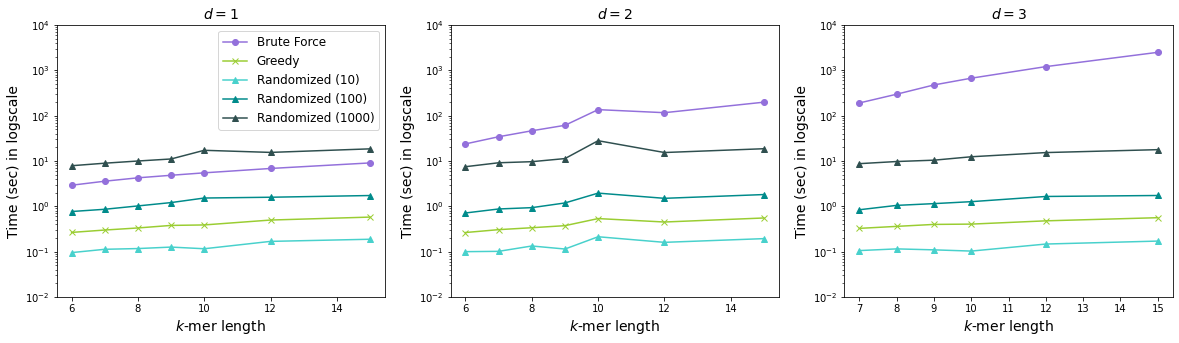

In [20]:
plt.figure(figsize=(20,5))

for i, d in enumerate(mismatches):
    kmer_range = [k for k in kmer_length if d < k/2]
    
    plt.subplot(1, len(mismatches), i+1)
    
    bf = [times['bf'][k,d] for k in kmer_range]
    gs = [times['gs'][k,d] for k in kmer_range]
    rs_10 = [times['rs_10'][k,d] for k in kmer_range]
    rs_100 = [times['rs_100'][k,d] for k in kmer_range]
    rs_1000 = [times['rs_1000'][k,d] for k in kmer_range]
    
    plt.plot(kmer_range, bf, marker='o', c='mediumpurple', label='Brute Force')
    plt.plot(kmer_range, gs, marker='x', c='yellowgreen', label='Greedy')
    plt.plot(kmer_range, rs_10, marker='^', c='mediumturquoise', label='Randomized (10)')
    plt.plot(kmer_range, rs_100, marker='^', c='darkcyan', label='Randomized (100)')
    plt.plot(kmer_range, rs_1000, marker='^', c='darkslategray', label='Randomized (1000)')
    
    plt.xlabel('$k$-mer length', fontsize=14)
    plt.ylabel('Time (sec) in logscale', fontsize=14)
    plt.title(f'$d={d}$', fontsize=14)
    plt.yscale('log')
    plt.ylim([1e-2,1e4])

    if d == mismatches[0]:
        plt.legend(fontsize=12)
plt.savefig('dfixed.pdf')

It can be noted from the plots above that the runtime performance varies more for the brute force algorithm than the other algorithms. As the number of mismatches increases, the algorithm becomes slower exponentailly. Moreover the length of the kmer affects the runtime proportionally as it increases as well. Interestingly, the performance of the greedy and randomized search algorithms seems to be unaffected by the increase in hte number of mismatches. More specifically, the runtime of the randomized search algorithm increases as the number of iterations increases too and as expected the randomized algorithm ran for $10$ iterations achieves the best score, while the randomized search algorithm ran for 1000 iterations and $d{=}1$ is outperformed by the brute force algorithm. The Greedy search is steadily the second best algorithm in terms of runtime performance. 

Below the plots present the runtimes of the three algorithms as $d$, number of mismatches, increases for a fixed length of kmer. As noted also from the previous plots, only the brute force algorithm seems to be affected by the increase in the number of mismatches. The larger the number of mismatches, the more slow the algorithm becomes. We also note that this observation stands for all kmer lenghts.

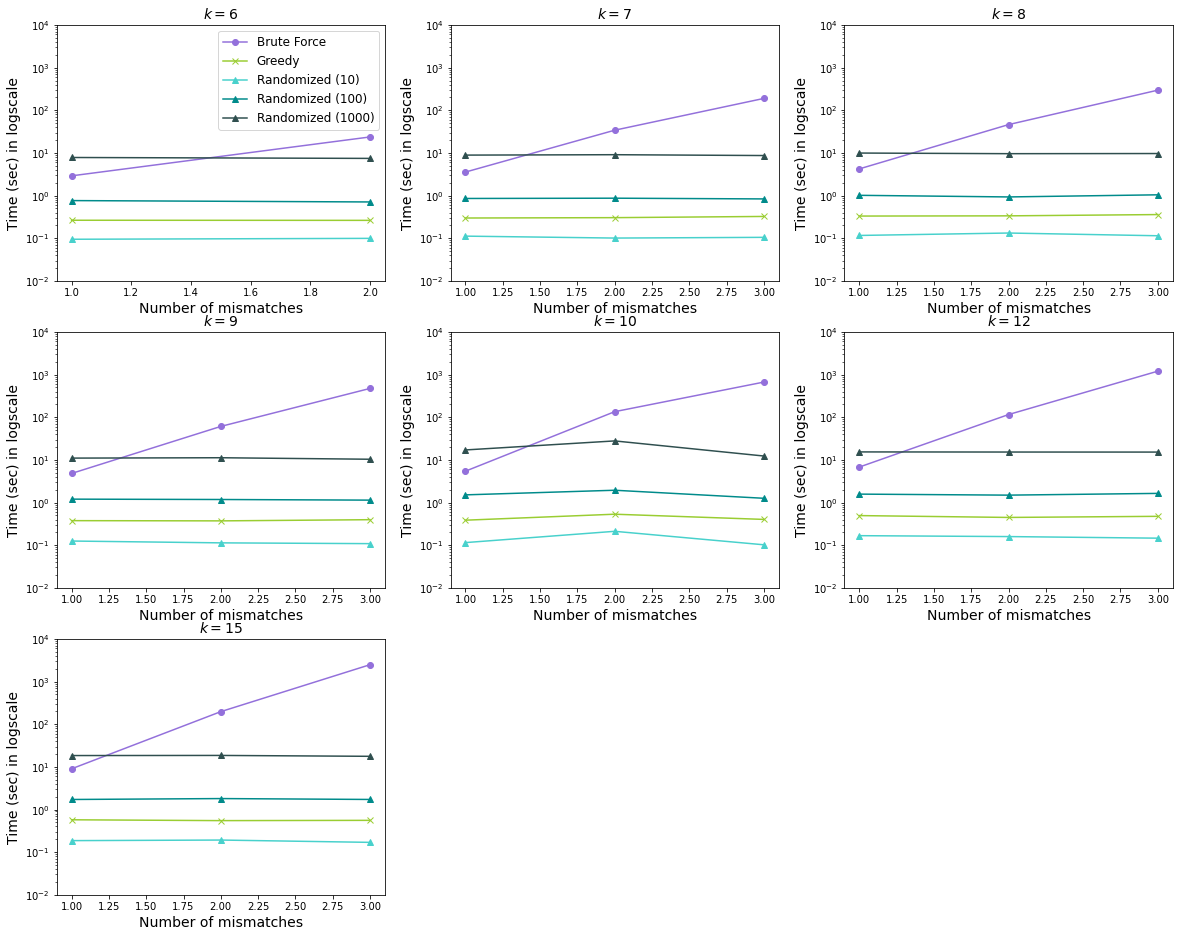

In [21]:
plt.figure(figsize=(20,16))

for i, k in enumerate(kmer_length):
    d_range = [d for d in mismatches if d < k/2]
    
    plt.subplot(3, 3, i+1)
    
    bf = [times['bf'][k,d] for d in d_range]
    gs = [times['gs'][k,d] for d in d_range]
    rs_10 = [times['rs_10'][k,d] for d in d_range]
    rs_100 = [times['rs_100'][k,d] for d in d_range]
    rs_1000 = [times['rs_1000'][k,d] for d in d_range]
    
    plt.plot(d_range, bf, marker='o', c='mediumpurple', label='Brute Force')
    plt.plot(d_range, gs, marker='x', c='yellowgreen', label='Greedy')
    plt.plot(d_range, rs_10, marker='^', c='mediumturquoise', label='Randomized (10)')
    plt.plot(d_range, rs_100, marker='^', c='darkcyan', label='Randomized (100)')
    plt.plot(d_range, rs_1000, marker='^', c='darkslategray', label='Randomized (1000)')
    
    plt.xlabel('Number of mismatches', fontsize=14)
    plt.ylabel('Time (sec) in logscale', fontsize=14)
    plt.title(f'$k={k}$', fontsize=14)
    plt.yscale('log')
    plt.ylim([1e-2,1e4])

    if k == kmer_length[0]:
        plt.legend(fontsize=12)
plt.savefig('kfixed.pdf')

# k-mer Quality 

In the plot below, we show the caclulated hamming distance of the most frequent k-dmer and the original kmer, and the consensus string and the original kmer, using the `hamming_distance` function, for the brute force and the greedy and randomized algorithms respectively. The ideal hamming distance is $0$, and thus the lower the hamming distance the better the result, in terms of accuracy.

More specifically for the case of **Brute Force** algorithm, since the algorithm returns a list of the most frequent k-d mers, we plot the best hamming distance, meaning the lowest from those caclulated.

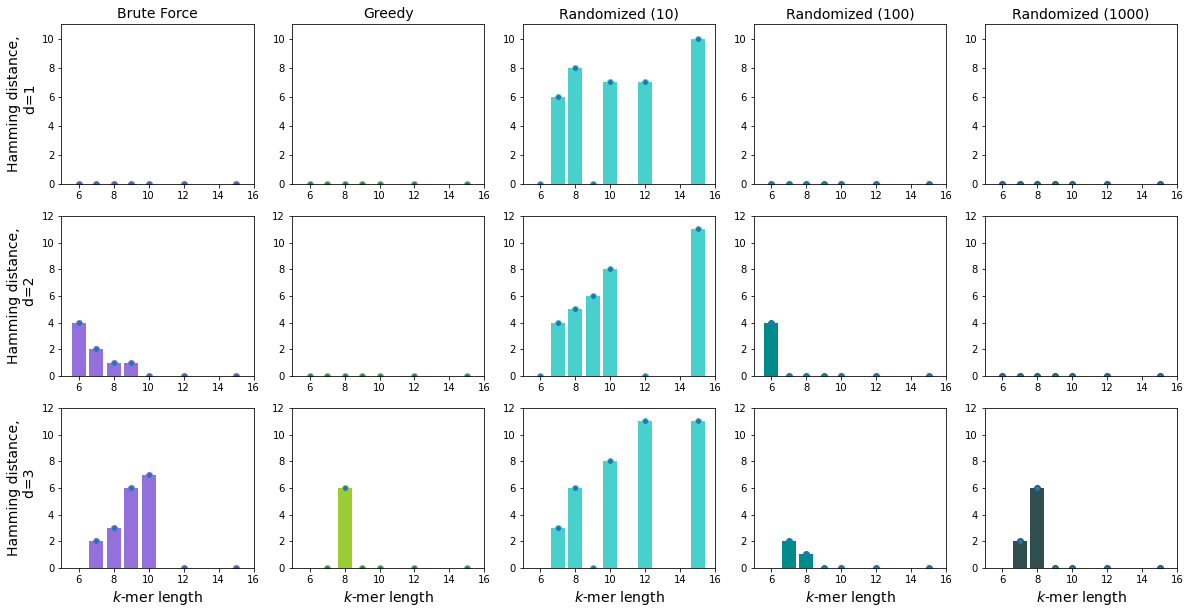

In [22]:
plt.figure(figsize=(20,10))

step = 1
for i, d in enumerate(mismatches):
    kmer_range = [k for k in kmer_length if d < k/2]
        
    bf = []
    for k in kmer_range:
        bf.append(min([hamming_distance(motif, datasets[k,d]['kmer']) for motif in results['bf'][k,d][0]]))
    
    gs = [hamming_distance(results['gs'][k,d][0], datasets[k,d]['kmer']) for k in kmer_range]
    rs_10 = [hamming_distance(results['rs_10'][k,d][0], datasets[k,d]['kmer']) for k in kmer_range]
    rs_100 = [hamming_distance(results['rs_100'][k,d][0], datasets[k,d]['kmer']) for k in kmer_range]
    rs_1000 = [hamming_distance(results['rs_1000'][k,d][0], datasets[k,d]['kmer']) for k in kmer_range]
    
    max_of_max = max([max(bf), max(gs), max(rs_10), max(rs_100), max(rs_1000)]) + 1
    
    plt.subplot(len(mismatches), len(results.keys()), step)
    plt.bar(kmer_range, bf, color='mediumpurple', label='Brute Force')
    plt.scatter(kmer_range, bf, marker='o', edgecolors='mediumpurple', label='Brute Force')
    plt.ylabel(f'Hamming distance,\n  d={d}', fontsize=14)
    if d == mismatches[0]:
        plt.title(f'Brute Force', fontsize=14)
    if d == mismatches[-1]:
        plt.xlabel('$k$-mer length', fontsize=14)
    plt.xlim([kmer_length[0]-1, kmer_length[-1]+1])
    plt.ylim([0, max_of_max])
    step += 1
    
    plt.subplot(len(mismatches), len(results.keys()), step)
    plt.bar(kmer_range, gs, color='yellowgreen', label='Greedy')
    plt.scatter(kmer_range, gs, marker='o', edgecolors='yellowgreen', label='Greedy')
    if d == mismatches[0]:
        plt.title(f'Greedy', fontsize=14)
    if d == mismatches[-1]:
        plt.xlabel('$k$-mer length', fontsize=14)
    plt.xlim([kmer_length[0]-1, kmer_length[-1]+1])
    plt.ylim([0, max_of_max])
    step += 1
    
    plt.subplot(len(mismatches), len(results.keys()), step)
    plt.bar(kmer_range, rs_10, color='mediumturquoise', label='Randomized (10)')
    plt.scatter(kmer_range, rs_10, marker='o', edgecolors='mediumturquoise', label='Randomized (10)')
    if d == mismatches[0]:
        plt.title(f'Randomized (10)', fontsize=14)
    if d == mismatches[-1]:
        plt.xlabel('$k$-mer length', fontsize=14)
    plt.xlim([kmer_length[0]-1, kmer_length[-1]+1])
    plt.ylim([0, max_of_max])
    step += 1
    
    plt.subplot(len(mismatches), len(results.keys()), step)
    plt.bar(kmer_range, rs_100, color='darkcyan', label='Randomized (100)')
    plt.scatter(kmer_range, rs_100, marker='o', edgecolors='darkcyan', label='Randomized (100)')
    if d == mismatches[0]:
        plt.title(f'Randomized (100)', fontsize=14)
    if d == mismatches[-1]:
        plt.xlabel('$k$-mer length', fontsize=14)
    plt.xlim([kmer_length[0]-1, kmer_length[-1]+1])
    plt.ylim([0, max_of_max])
    step += 1
    
    plt.subplot(len(mismatches), len(results.keys()), step)
    plt.bar(kmer_range, rs_1000, color='darkslategray', label='Randomized (1000)')
    plt.scatter(kmer_range, rs_1000, marker='o', edgecolors='darkslategray', label='Randomized (1000)')
    if d == mismatches[0]:
        plt.title(f'Randomized (1000)', fontsize=14)
    if d == mismatches[-1]:
        plt.xlabel('$k$-mer length', fontsize=14)
    plt.xlim([kmer_length[0]-1, kmer_length[-1]+1])
    plt.ylim([0, max_of_max])
    step += 1

plt.savefig('hamming.pdf')

As it shown in the plot above, the worst performance in terms of accuracy is achieved by the randomized search algorithm, ran for 10 iterations, as expected. It can be noted that for $d{=}1$ mismatche, all the algorithms apart from the randomized ran for 10 iterations achieve high quality results, regardless of the length of the kmer. As the number of mismatches increases, the performance of all the algorithms decreases. Keep in mind, that for instance, when we have $d{=}3$, $3$ mismatches are accepted and thus a hamming distance of $3$ can be cosnidered a success. Overall, the greedy and the randomized (for $>10$ iterations) search algorithms, yield the best results. 

# Conclusions

We performed experimental evaluation using three algorithms for identifying the subsequence (kmer), implanted in a number of DNA sequences. One brute force searching for the exact solution, one greedy search aiming to find a good solution by making locally optimal choices at each step, and a randomized search, examining random candidates until a satisfactory solution is found.

The results suggest that the brute force algorithm, as expected, always finds an exact solution when possible (for large $k$). However, this solution comes with a cost in runtime performance, which is exponential in terms of the legth of the kmer and the number of mismatches allowed. On the other hand, the greedy search algorithm appears to be much faster in all cases in addition to finding high quality solutions very close (or even exact) to the original kmer. Finally, the randomized search algorithm yields runtime perfomance which is proportional to the number of iterations. For a small number of iterations, e.g., $10$, the algorithm is exceptionally fast, however giving very poor results in terms of accuracy. On the other end, for a very large number of iterations, e.g., $1000$, the algorithm finds, high qualtiy solutions, similar to that of the greedy search, but the runtime performance is compromised, since it is the second slower after the brute force. The middle ground, e.g., $100$ iterations, achieves a balanced performance both in terms of accuracy and run time. In our experimental evalutaion, the greedy and the randomized ($1000$) search algorithms achieve similar accuracy, while the greedy search algorithms is faster in most cases. To that end, the greedy search algorithm seems to be the way to go.